# Prepare robots first  
* run panda repeater on controller pc  

```
ssh panda@192.168.0.172
roslaunch panda_ros_repeater joint_velocity_repeater.launch robot_ip:=192.168.0.13 load_gripper:=false

```

* Keep indy connected to conty to bypass conty-connection delay bug

# initialize notebook

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Initialize constants

In [2]:
from pkg.marker_config import *
from pkg.constraint_graph import *
from pkg.constraint.constraint_action import *
from pkg.constraint.constraint_object import *
from pkg.constants import *
from pkg.utils.plot_utils import *
from pkg.utils.utils import *
from pkg.environment_builder import *
from pkg.ui.ui_broker import *
from pkg.controller.combined_robot import *

gtimer = GlobalTimer.instance()
gtimer.reset()

In [3]:
crob = CombinedRobot(connection_list=(False, False))

connection_list
(False, False)


# initialize graph & ui

In [4]:
if "cam" not in locals():
    cam = None # StereoCamera.instance()

# set urdf
xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, XYZ_RPY_ROBOTS_DEFAULT, crob.custom_limits, start_rviz=True)
ghnd = GeometryHandle(urdf_content)


graph = ConstraintGraph(ghnd=ghnd, urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                        urdf_content=urdf_content, combined_robot=crob)
graph.set_camera(cam)
graph.set_cam_robot_collision(_add_cam_poles=False)
graph.set_rviz()

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(graph)
ui_broker.start_server()

# set rviz
graph.set_rviz(crob.home_pose)
ui_broker.set_tables()

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [5]:
from pkg.planner.moveit import moveit_py
from pkg.planner.moveit.moveit_planner import MoveitPlanner

### Set Planner

In [6]:
mplan = MoveitPlanner(
    joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path, urdf_content=graph.urdf_content, 
    robot_names=crob.robot_names, ghnd=ghnd)

### define tool

In [7]:
GROUP_NAME, TOOL_LINK, BASE_LINK  = "indy0", "indy0_tcp", "base_link"
TOOL_XYZRPY = ((0,0,0.14),(np.pi,0,0))
# TOOL_XYZRPY = ((0,0,0),(0,0,0))
# ORIGIN_XYZRPY = ((0,0,0.4), (0,0,0))
ORIGIN_XYZRPY = (( -0.637836,   -0.102947,  0.527019  ), (3.14151544, -0.01124507,  1.55726101))

TOOL_TF = T_xyzrpy(TOOL_XYZRPY)
TOOL_XYZQUAT = T2xyzquat(TOOL_TF)
ORIGIN_TF = T_xyzrpy(ORIGIN_XYZRPY)

### Show constraints

In [8]:
mtem_list=[]

In [23]:
for mtem in mtem_list:
    graph.remove_geometry(mtem)
mtem_list=[]

In [24]:
# mtem_list.append(ghnd.create_safe(gtype=GEOTYPE.BOX, name="plane", link_name="base_link",
#                                       center=ORIGIN_XYZRPY[0], rpy=ORIGIN_XYZRPY[1], 
#                                       dims=(3,3,0.001), color=(1, 1, 0, 0.5),
#                                       collision=False))
# mtem_list.append(ghnd.create_safe(gtype=GEOTYPE.CYLINDER, name="cylinder", link_name="base_link",
#                                       center=np.add(ORIGIN_XYZRPY[0], (0.05,0,0)), rpy=ORIGIN_XYZRPY[1], 
#                                       dims=(0.1,0.1,0.1), color=(1, 1, 0, 0.5),
#                                       collision=False))
mtem_list.append(ghnd.create_safe(gtype=GEOTYPE.SPHERE, name="cylinder", link_name="base_link",
                                      center=np.add(ORIGIN_XYZRPY[0], (0.05,0,0)), rpy=ORIGIN_XYZRPY[1], 
                                      dims=(0.1,0.1,0.1), color=(1, 1, 0, 0.5),
                                      collision=False))
for mtem in mtem_list:
    graph.add_marker(mtem)

### move to starting pose

In [25]:
Q_init = crob.home_pose
goal_pose = T2xyzquat(np.matmul(ORIGIN_TF, TOOL_TF))
trajectory, success = mplan.planner.plan_py(robot_name=GROUP_NAME, tool_link=TOOL_LINK, goal_pose=goal_pose[0]+goal_pose[1], goal_link=BASE_LINK, 
                                            Q_init=Q_init, plannerconfig="RRTConnectkConfigDefault", timeout=1)
Q_ready = trajectory[-1]

In [26]:
graph.show_motion(trajectory)
graph.show_pose(Q_ready)
print("goal pose: {}".format(goal_pose))
print("Q_ready: {}".format(np.round(Q_ready,2)))

goal pose: ([-0.637803852558136, -0.10137300938367844, 0.3870278596878052], [0.003921231635065741, -0.004029640151390661, 0.7022939191396269, 0.7118649008640737])
Q_ready: [-0.   -2.82  2.18 -0.    0.64 -3.14  0.   -0.39  0.   -1.57  0.    1.57
  1.57]


### set manifolds

In [32]:
mplan.planner.clear_context_cache()
mplan.planner.clear_manifolds()
ctem_list = make_constraint_list(mtem_list)
mplan.planner.add_union_manifold_py(group_name=GROUP_NAME, tool_link=TOOL_LINK, tool_offset=TOOL_XYZQUAT[0]+TOOL_XYZQUAT[1], 
                                    geometry_list=ctem_list, fix_surface=False, fix_normal=True, radius=1e-5, tol=2e-3)

### search plan

In [33]:
tool_tf = np.matmul(get_tf(TOOL_LINK, list2dict(Q_ready, mplan.joint_names), mplan.urdf_content), T_xyzrpy(TOOL_XYZRPY))
goal_pose = T2xyzquat(np.matmul( \
                                np.matmul(ORIGIN_TF, SE3(np.identity(3), (0.0,0.1,0.0))),
                                TOOL_TF))

In [34]:
trajectory, success = mplan.planner.plan_constrained_py(GROUP_NAME,TOOL_LINK, goal_pose[0]+goal_pose[1], BASE_LINK, Q_ready, timeout=60)
print('result: {} ({})'.format(success, len(trajectory)))

RuntimeError: wrong jacobian calculation 

In [30]:
graph.show_motion(trajectory, period=0.01)

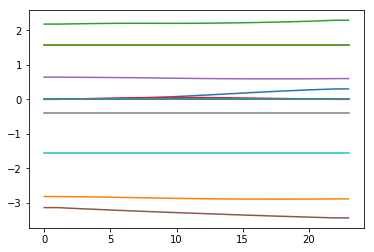

In [31]:
plt.plot(trajectory)

In [25]:
for mtem in mtem_list:
    graph.remove_geometry(mtem)

array([-0.6780565, -0.3631056,  0.652356 ])

In [47]:
np.linalg.norm(np.subtract(str2num_split_blank("-0.587836   -0.102947    0.527019"), 
                           get_tf("indy0_tcp", list2dict([-0.696546, -1.52706, 0.545226, 2.94653, -1.71177, -3.65257]+[0]*7, graph.joint_names), graph.urdf_content)[:3,3]))

0.30254189724992736

In [55]:
np.linalg.norm(np.subtract(str2num_split_blank("-0.587836   -0.102947    0.527019"), 
                           get_tf("indy0_tcp", list2dict(str2num_split_blank("0.110842 -0.384913  -1.15123 0.0380885  -2.21211  -2.13386")+[0]*7, graph.joint_names), graph.urdf_content)[:3,3])) - 0.05

0.008209728784035399

In [56]:
np.linalg.norm(np.subtract(str2num_split_blank("-0.587836   -0.102947    0.527019"), 
                           get_tf("indy0_tcp", list2dict(str2num_split_blank("0     0 -1.57     0 -1.57     0     0  -0.4     0 -1.57     0  1.57  1.57"), graph.joint_names), graph.urdf_content)[:3,3])) - 0.05

-2.885570144911531e-07

In [59]:
np.linalg.norm([str2num_split_blank("-0.119472 0.00136604  -0.162475   0.116895  -0.298804          0")])

0.378974698252115

In [ ]:
str2num_split_blank("-0.187945  -0.557526   -0.53147   0.360739  -0.699756          0")

In [59]:
np.linalg.norm([str2num_split_blank("-0.119472 0.00136604  -0.162475   0.116895  -0.298804          0")])

0.378974698252115

In [61]:
np.array(
    [str2num_split_blank("-0.119472 0.00136604  -0.162475   0.116895  -0.298804          0"),
     str2num_split_blank("-0.187945  -0.557526   -0.53147   0.360739  -0.699756          0")])

array([[-0.119472  ,  0.00136604, -0.162475  ,  0.116895  , -0.298804  ,
         0.        ],
       [-0.187945  , -0.557526  , -0.53147   ,  0.360739  , -0.699756  ,
         0.        ]])